# Predicting anomalies in **critical infrastructure** with photonic fiber optic quantum sensing and QML

In the current notebook, we implement the QML module.


**_Core algorithm_** VQE

**_Problem definition_** Binary classifier: normal or anomaly

**_Dataset_** synthetic through randomized Hamiltonian

In [146]:
# Imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.minimum_eigensolvers import vqe
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import Pauli, Operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import train_test_split
from qiskit.quantum_info import Statevector
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

### Synthetic dataset creation

We create a randomized Hamiltonian that, if applied, models the presence of an anomaly in the infrastructure.

In [100]:
def hamiltonian_creation (num_qubits, w_0):
    
    # Initialize circuit and qubit states
    quantum_register = QuantumRegister(num_qubits, 'qubits')
    circuit = QuantumCircuit(quantum_register)
    circuit.h(quantum_register[0])
    circuit.cx(quantum_register[0], quantum_register[1:num_qubits])
    
    # Apply Hamiltonian to each qubit
    matrix = np.array([[1,0],[0, np.exp(-1j * w_0)]])
    operator = Operator(matrix)
    circuit.unitary(operator, quantum_register[0:num_qubits], label = 'U(w_0)')
    
    # Retrieve qubit states
    statevector_list = []
    full_statevector = Statevector(circuit)
    for i in range(num_qubits):
        statevector_list.append()
    
    return circuit, statevector_list

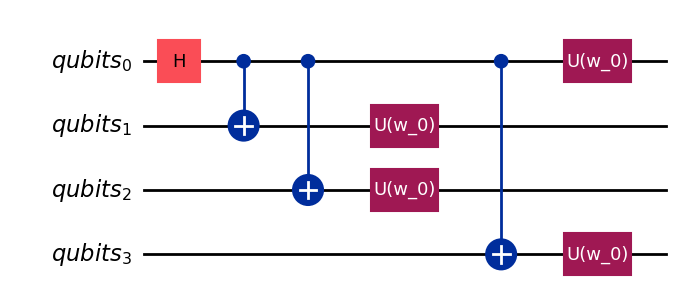

In [101]:
# Example for 4 qubits
hamiltonian_creation(4, 0.2)[0].draw('mpl')

In [ ]:
hamiltonian_creation(4, 0.2)

We now proceed to the dataset creation the generic implementation of the data preparation. Now, our particular model will consist on:
 
- The system shall be composed of 10 qubits.
- w_0 = 0 is assumed to be the normal state ("-1"). 
- w_0 ≠ 0 is assumed to be an anomaly ("1").

The synthethic data will consist of an imposed 50% "normal" states and 50% randomized w_0, that will be either anomaly or normal. Given that each w_0 is correlated to a quantum state, the QML model will infer the w_0 from the quantum state and thus generate the corresponding label.

In [132]:
# Particular model creation with Pandas
row_count = 100
qubits_in_system = 10
normal_w_0 = 0
columns = ['quantum_state', 'label']
quantum_states = []
labels = []
for i in range(row_count):
    if i < row_count / 2:
        quantum_states.append(hamiltonian_creation(qubits_in_system, 
                                                   normal_w_0)[0])
        labels.append(-1)
    else:
        w_0_i = np.random.rand() * 2 * np.pi
        quantum_states.append(hamiltonian_creation(qubits_in_system, 
                                                   w_0_i)[0])
        if w_0_i == 0:  # should check if this is OK
            labels.append(-1)
        else:
            labels.append(1)
    
list_of_tuples = list(zip(quantum_states, labels))
dataset = pd.DataFrame(list_of_tuples, columns = columns)


In [133]:
# Dataset format
dataset.head()

,quantum_state,label
0,"((Instruction(name='h', num_qubits=1, num_clbi...",-1
1,"((Instruction(name='h', num_qubits=1, num_clbi...",-1
2,"((Instruction(name='h', num_qubits=1, num_clbi...",-1
3,"((Instruction(name='h', num_qubits=1, num_clbi...",-1
4,"((Instruction(name='h', num_qubits=1, num_clbi...",-1


### Variational Quantum Classifier

In [135]:
train, test = train_test_split(dataset, test_size=0.2)
X_train = pd.Series.to_numpy(train['quantum_state'])
Y_train = pd.Series.to_numpy(train['label'])
X_test = pd.Series.to_numpy(test['quantum_state'])
Y_test = pd.Series.to_numpy(test['label'])

In [142]:
from qiskit_aqua.components.feature_maps import FeatureMap
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import BlueprintCircuit

class CustomFeatureMap(FeatureMap):
    """Mapping data with a custom feature map."""
    
    def __init__(self, feature_dimension, depth=2, entangler_map=None):
        """
        Args:
            feature_dimension (int): number of features
            depth (int): the number of repeated circuits
            entangler_map (list[list]): describe the connectivity of qubits, each list describes
                                        [source, target], or None for full entanglement.
                                        Note that the order is the list is the order of
                                        applying the two-qubit gate.        
        """
        self._support_parameterized_circuit = False
        self._feature_dimension = feature_dimension
        self._num_qubits = self._feature_dimension = feature_dimension
        self._depth = depth
        self._entangler_map = None
        if self._entangler_map is None:
            self._entangler_map = [[i, j] for i in range(self._feature_dimension) for j in range(i + 1, self._feature_dimension)]
            
    def construct_circuit(self, x, qr, inverse=False):
        """Construct the feature map circuit.
        
        Args:
            x (numpy.ndarray): 1-D to-be-transformed data.
            qr (QauntumRegister): the QuantumRegister object for the circuit.
            inverse (bool): whether or not to invert the circuit.
            
        Returns:
            QuantumCircuit: a quantum circuit transforming data x.
        """
        qc = QuantumCircuit(qr)

        
        for _ in range(self._depth):
            for i in range(self._feature_dimension):
                qc.rx(x[i], qr[i])
            for [source, target] in self._entangler_map:
                qc.cx(qr[source], qr[target])
                qc.u1(x[source] * x[target], qr[target])
                qc.cx(qr[source], qr[target])
                    
        if inverse:
            qc.inverse()
        return qc
    
    


ModuleNotFoundError: No module named 'qiskit_aqua'

In [137]:
# construct feature map, ansatz, and optimizer
num_inputs = train.shape[0]
feature_map = X_train
ansatz = RealAmplitudes(qubits_in_system, reps=1)

# construct variational quantum classifier
vqc = VQC(
    num_qubits = qubits_in_system,
    feature_map = feature_map,
    ansatz = ansatz,
    loss = "cross_entropy",
    optimizer = COBYLA(maxiter = 30),
)

AttributeError: 'numpy.ndarray' object has no attribute 'num_qubits'

In [122]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X_train, Y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X_test, Y_test)

QiskitMachineLearningError: 'Input data has incorrect shape, last dimension is not equal to the number of inputs: 10, but got: 80.'

In [ ]:
# evaluate data points
y_predict = vqc.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()